# Checking calibrations

Here I am just checking the calibrations measured for all $z-\lambda$ bins.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import emcee
import corner
%matplotlib inline
plt.rc("errorbar", capsize=3)

In [4]:
cs = ['maroon','red','blue','cyan']
zs = [1.0, 0.5, 0.25, 0.]

In [5]:
def add_points(ax, sigma=None):
    for i in range(4):
        for j in range(4):
            h = i*4+j
            lam = data[3,h]
            c = data[4,h]
            ce = data[5,h]
            if sigma is not None:
                ce = sigma
            if j == 0:
                ax.errorbar(lam, c, ce, color=cs[i], marker='.', label="z=%.2f"%zs[i], ls='')
            else:
                ax.errorbar(lam, c, ce, color=cs[i], marker='.')
    ax.set_ylim(0.9, 1.15)
    ax.legend(loc="upper left")

# Modeling the calibration

In [26]:
def lnlike(params, args, ret_model=False):
    C0, alpha, beta, sigcal = params
    if sigcal < 0: return -1e99
    lams = args['lams'].T
    zs = args['zs']
    #print(lams)
    #print(zs)
    C = args['C']
    Cerr = args['Cerr']
    model = C0*(lams/30.)**alpha * ((1+zs)/1.5)**beta
    if ret_model:
        return model
    X = C - model
    LL = 0
    for i in range(len(X)):
        for j in range(len(X[0])):
            LL += -0.5*np.log(sigcal**2)-0.5*X[i,j]**2/sigcal**2
    return LL
guess = [1.0, 0.05 ,0.05, 0.1]
print(lnlike(guess, args5))

34.91589689376309


In [7]:
def make_args(sig):
    path = "result_%0.2fsigintr.npy"%sig
    data = np.load(path)
    print(data.shape)
    zs = [1.0, 0.5, 0.25, 0.]
    zarr = np.zeros((4,4))
    lamarr = np.zeros((4,4))
    C = np.zeros((4,4))
    Ce = np.zeros((4,4))
    for i in range(16):
        zarr[i%4, i/4] = zs[i%4]
        lamarr[i%4, i/4] = data[3, i]
        C[i%4, i/4] = data[4,i]
        Ce[i%4, i/4] = data[5,i]
    args = {"lams": lamarr, "zs":zarr, "C":C, "Cerr":Ce}
    return args
args5 = make_args(.05)
args40 = make_args(.40)

(6, 16)
(6, 16)


In [38]:
guess = [1.0, 0.05 ,0.05, 0.1]
print(lnlike(guess, args40))
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, guess, args=args5)
cov = result['hess_inv']
print result

35.37425498581573
      fun: -67.5235695099098
 hess_inv: array([[ 8.31954692e-06, -8.51217009e-06,  5.73051785e-06,
         1.13549991e-07],
       [-8.51217009e-06,  2.40416958e-05,  1.70362017e-06,
         4.16594312e-08],
       [ 5.73051785e-06,  1.70362017e-06,  7.20815987e-05,
         2.49872852e-07],
       [ 1.13549991e-07,  4.16594312e-08,  2.49872852e-07,
         2.38276407e-06]])
      jac: array([ 3.81469727e-06,  9.53674316e-07,  6.67572021e-06, -2.86102295e-06])
  message: 'Optimization terminated successfully.'
     nfev: 299
      nit: 23
     njev: 47
   status: 0
  success: True
        x: array([ 1.04349913, -0.02269669, -0.05279047,  0.00891318])


(0.95, 1.15)

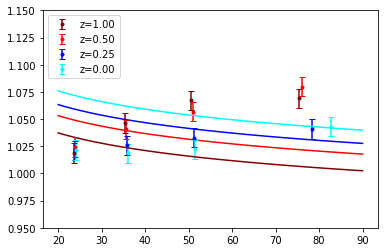

In [39]:
fig, ax = plt.subplots(1,1)
l = np.linspace(20,90)
plot_args = args5.copy()
for i,z in enumerate(zs):
    plot_args['lams'] = l
    plot_args['zs'] = z
    model = lnlike(result.x, plot_args, True)
    ax.plot(l, model, c=cs[i])
add_points(ax, result.x[-1])
ax.set_ylim(.95,1.15)

In [40]:
ndim = 4
nwalkers = 32
nsteps = 1000
nburn = 200
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, args=(args5,), threads=4)

In [41]:
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler.run_mcmc(pos, nburn)
print("burn in done")

burn in done


In [42]:
chain = sampler.chain
pos = chain[:,-1,:]
print(chain.shape)

(32, 200, 4)


In [43]:
sampler.reset()

In [44]:
sampler.run_mcmc(pos, nsteps)
print("mcmc complete")

mcmc complete


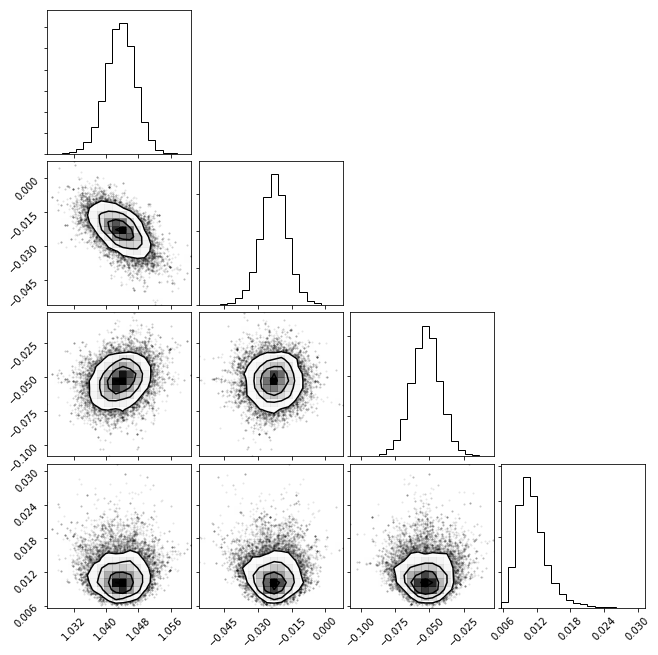

In [45]:
chain = sampler.flatchain
lnlikes = sampler.flatlnprobability
fig = corner.corner(chain)
cov = np.cov(chain.T)

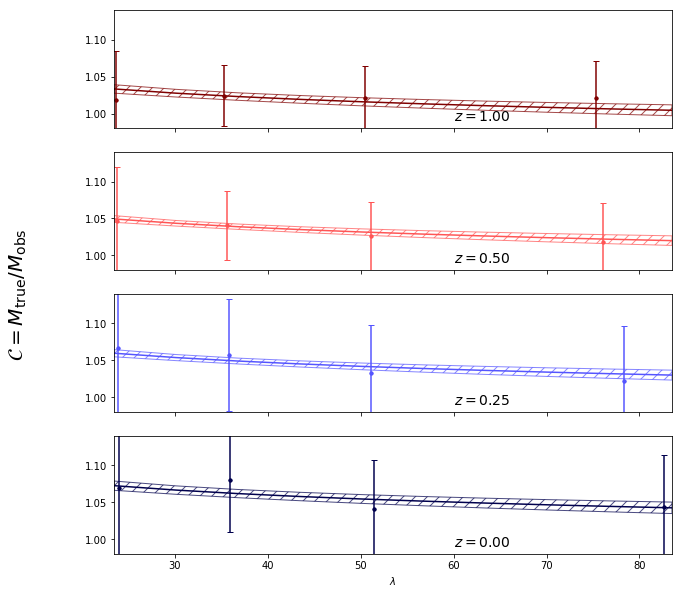

In [46]:
zs = [1.0, 0.5, 0.25, 0.]
fig, ax = plt.subplots(4,1, sharex=True, figsize=(10,10))
colors = [plt.get_cmap("seismic")(ci) for ci in np.linspace(1.0, 0.0, len(zs))]
C0, a, b, sc = chain[np.argmax(lnlikes)]
params5 = np.array([C0,a,b,sc])
vC0,va,vb, vsc = cov.diagonal()
cal = args5['C']
scal = args5['Cerr']
lams = args5['lams'].T
lamx = np.linspace(np.min(lams)*0.99, np.max(lams)*1.01, num=10)
for i in range(len(zs)):
    C = C0 * (lamx/30.)**a * ((1+zs[i])/1.5)**b
    C_err = np.sqrt(vC0*C**2/C0**2 + va*C**2*np.log(lamx/30.)**2 + vb*C**2*np.log((1+zs[i])/1.5)**2 + cov[0,1]*C**2/C0*np.log(lamx/30.) + cov[0,2]*C**2/C0*np.log((1+zs[i])/1.5) + cov[1,2]*C**2*np.log(lamx/30.)*np.log((1+zs[i])/1.5))
    ax[i].plot(lamx, C, c=colors[i])
    ax[i].fill_between(lamx, C+C_err, C-C_err, alpha=0.7, hatch='//', facecolor='none', edgecolor=colors[i])
    ax[i].errorbar(lams[i], cal[i], scal[i], marker='.', ls='', c=colors[i])
    ax[i].scatter(lams[i], cal[i], marker='.', color=colors[i])
    yulim = 1.14
    ax[i].set_ylim(0.98, yulim)
    ax[i].set_xlim(min(lamx), max(lamx))
    ax[i].text(60, 0.99, r"$z=%.2f$"%zs[i], fontsize=14)
    if i == 2:
        ax[i].text(12, yulim, r"$\mathcal{C}=M_{\rm true}/M_{\rm obs}$", rotation='vertical', fontsize=20, va='center') 
    ax[-1].set_xlabel(r"$\lambda$")
#fig.savefig("calibration_sigint%dpercent.png"%(100*sig), dpi=300, bbox_inches='tight')

In [47]:
print(C0, a, b, sc)

(1.0436260327021019, -0.02236970623747466, -0.053219449421671464, 0.00900770721048671)


In [48]:
print(params40)
print(params5)

[ 1.03722093 -0.00673755 -0.04395345  0.00927532]
[ 1.04362603 -0.02236971 -0.05321945  0.00900771]


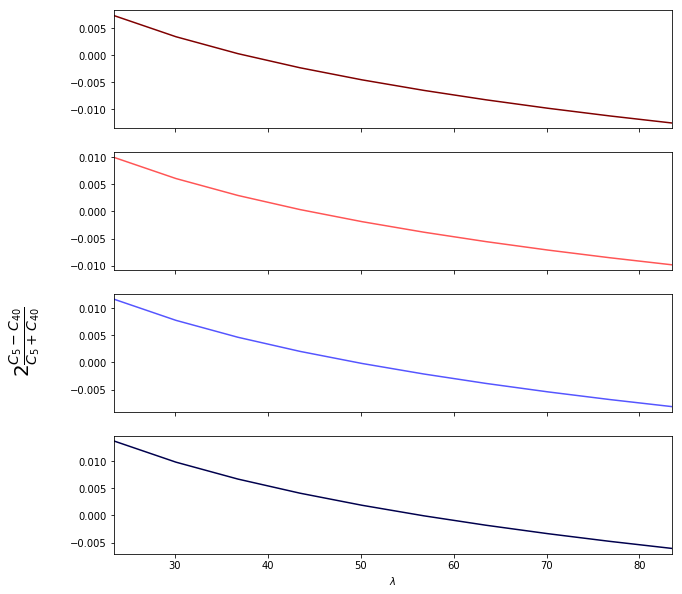

In [61]:
fig, ax = plt.subplots(4,1, sharex=True, figsize=(10,10))
for i in range(len(zs)):
    CS = []
    for params in [params5, params40]:
        C0, a, b, sc = params
        C = C0 * (lamx/30.)**a * ((1+zs[i])/1.5)**b
        C_err = np.sqrt(vC0*C**2/C0**2 + va*C**2*np.log(lamx/30.)**2 + vb*C**2*np.log((1+zs[i])/1.5)**2 + cov[0,1]*C**2/C0*np.log(lamx/30.) + cov[0,2]*C**2/C0*np.log((1+zs[i])/1.5) + cov[1,2]*C**2*np.log(lamx/30.)*np.log((1+zs[i])/1.5))
        CS.append(C)
        #ax[i].plot(lamx, C, c=colors[i])
        #ax[i].fill_between(lamx, C+C_err, C-C_err, alpha=0.7, hatch='//', facecolor='none', edgecolor=colors[i])
        #ax[i].errorbar(lams[i], cal[i], scal[i], marker='.', ls='', c=colors[i])
        #ax[i].scatter(lams[i], cal[i], marker='.', color=colors[i])
    ax[i].plot(lamx, 2*(CS[0] - CS[1])/(CS[0]+CS[1]), c=colors[i])
    yulim = 0.004
    #ax[i].set_ylim(0.98, yulim)
    ax[i].set_xlim(min(lamx), max(lamx))
    #ax[i].text(60, 0.99, r"$z=%.2f$"%zs[i], fontsize=14)
    if i == 2:
        ax[i].text(12, yulim, r"$2\frac{C_5 - C_{40}}{C_5+C_{40}}$", rotation='vertical', fontsize=20, va='center') 
    ax[-1].set_xlabel(r"$\lambda$")
fig.savefig("calibration_difference.png", dpi=300, bbox_inches='tight')